# Finetuning MoonShine in PyTorch

## Data
Using the Tensorflow mini speech command dataset to get up and running. See https://www.tensorflow.org/tutorials/audio/simple_audio for sources

In [1]:
# ensure vscode reloads python files
%load_ext autoreload
%reload_ext autoreload
from download_mini_speech_commands import downloadMiniSpeech

downloadMiniSpeech()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Zip file already exists, skipping download.
Dataset already extracted.


(16000,)


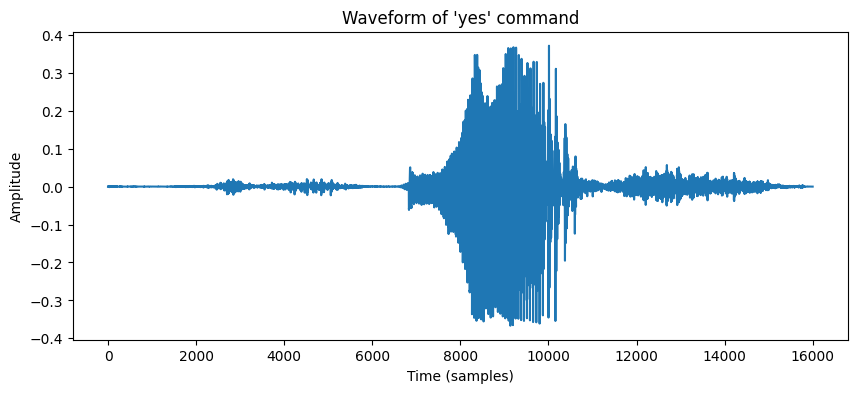

torch.Size([1, 1, 16000])


In [2]:
# load an example entry
import librosa
import torch
import matplotlib.pyplot as plt

numSamplesPerSecond = 16000 # The sample rate, see https://librosa.org/doc/latest/glossary.html#term-sampling-rate
audio, sr = librosa.load("./data/mini_speech_commands/yes/0ab3b47d_nohash_0.wav", sr=numSamplesPerSecond)
print(audio.shape) # (16000,)

plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title("Waveform of 'yes' command")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

audio = torch.tensor(audio)
audio = torch.reshape(audio, (1, 1, -1)) # (batch_size, num_channels, num_samples)
print(audio.shape) # (1, 16000)

## Preprocessor block

Moonshine base model `MoonShine(dim=288, innerdim=288, n_head=8, n_enc_layers=6, n_dec_layers=6)`

In [5]:
moonshineBaseConfig = {
    "preprocesserDims": 288,
    "innerDim": 288,
    "nHead": 8,
    "nEncoder": 6,
    "nDecoder": 6
}

In [6]:
def diskSizeOfModel(model):
    numBytesPerParameter = torch.tensor([], dtype=torch.float32).element_size() # A 32-bit float takes 4 bytes
    tensorSizeBytes = sum(p.numel() for p in model.parameters()) * numBytesPerParameter
    # human readable size
    if tensorSizeBytes < 1024:
        return f"{tensorSizeBytes} bytes"
    elif tensorSizeBytes < 1024**2:
        return f"{tensorSizeBytes / 1024:.2f} KB"
    elif tensorSizeBytes < 1024**3:
        return f"{tensorSizeBytes / 1024**2:.2f} MB"
    else:
        return f"{tensorSizeBytes / 1024**3:.2f} GB"

In [8]:
from model import AudioPreprocessor

preprocessor = AudioPreprocessor(dim=moonshineBaseConfig["preprocesserDims"])
x = preprocessor(torch.randn(1, 1, 16000)) # (batch_size, num_channels, num_samples)

# Test the preprocessor with the example audio
x = preprocessor(audio)
print(x.shape) # (B, C, T)

total_params = sum(p.numel() for p in preprocessor.parameters())
print(f"Total number of parameters in preprocessor: {total_params}, with disk size of {diskSizeOfModel(preprocessor)}")

torch.Size([1, 288, 40])
Total number of parameters in preprocessor: 1695456, with disk size of 6.47 MB
